# Visualization of the trained model

In this notebook we will mainly visualize what's the model capable of. Additionally, we will also visualize some of its internal components as the data goes through them, such as the alpha scores or the features from the Encoder.

Let's first import the necessary libraries

## Imports

In [1]:
# Import of the model structure
from utils.utils import *
from models.models import *

# Data manipulation
import numpy as np
import torchvision.transforms as T

# Visualization
import matplotlib.pyplot as plt
from utils.visualizations import *

# Other useful libraries
import sys

C:\Users\donai\Anaconda3\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Loading the model

**Important**: Change the following paths to match the location where your data is stored. In the next cell I'm assuming that you have a folder named `logs` inside the folder `data` with the *trained* model. If you don't, simply execute the model and the `.pth` file will be automatically generated in the `logs` folder.

In [2]:
DATA_LOCATION = '../data'
model_path = DATA_LOCATION + '/logs/EncoderDecorder_model.pth'

We choose the hardware we are using to run this notebook.

In [3]:
device = 'cpu' # or 'cuda:0'

Finally, we load the model using the custom function `load_ED_model()`. Make sure to indicate in the third arguement which Encoder you used to train the model you're loading. Otherwise the weights won't match and it will return an error.

In [4]:
model = load_ED_model(model_path, device, 'ResNet152')


## Visualizing the saved image and caption for a certain epoch

When the model is trained, an image and a caption is saved as a `.joblib` file every time an epoch finishes. It is the same image throughout all epochs, so that allow us to see how the captioning improves.

Let's load the results from some epochs. In particular, the model I'm visualizing has been trained for 10 epochs, so I will visualize, for example, the epochs 1, 5 and 10. Note that the epoch is specified in the name of the `.joblib` file.

In [5]:
caption1 = joblib.load(DATA_LOCATION + '/logs/Captions/caption_epoch_1.joblib')
image1 = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_1.joblib')

caption2 = joblib.load(DATA_LOCATION + '/logs/Captions/caption_epoch_5.joblib')
image2 = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_5.joblib')

caption3 = joblib.load(DATA_LOCATION + '/logs/Captions/caption_epoch_10.joblib')
image3 = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_10.joblib')

And now we show them using the `show_image()` function.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


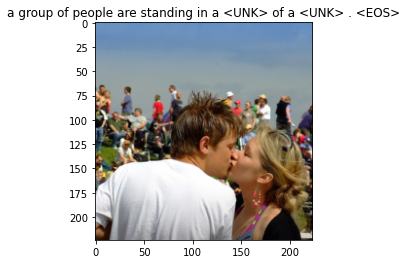

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


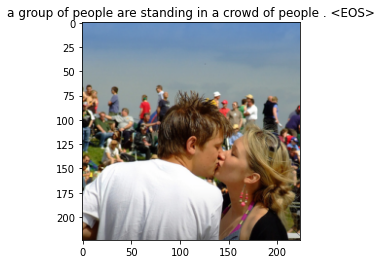

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


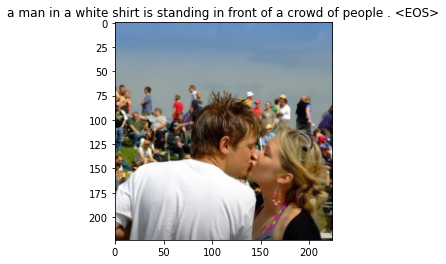

In [6]:
plt.figure(figsize=(4, 4))
show_image(image1, caption1)
show_image(image2, caption2)
show_image(image3, caption3)

We can indeed see a clear improvement in the captioning of this image!

## Feeding the model other images from the test dataset

If we want to feed the model other images from the dataset, we will have to load the dataset *in situ*. For this purpose, we will create a small dictionary (a smaller version of the `config` dictionary in `main`) with the necessary options to run the functions that load the dataset. The options should be the same that have been used to train the model.

In [7]:
config_viz = dict(
    # Paths
    DATA_LOCATION=DATA_LOCATION,

    # Training data
    batch_size=50,
    train_size=0.8,
)

The following function loads the dataset from the `processed_dataset.joblib` file. Make sure you have executed at least once the function `generate_and_dump_dataset()` to generate this file.

In [8]:
dataset = make_dataset_notebook(config_viz)

Now we get the vocabulary from the captions of the dataset.

In [9]:
vocab = dataset.vocab

And finally we get the train and test loaders from which we will be able to get new images.

In [10]:
train_loader, test_loader = make_dataloaders_notebook(config_viz, dataset, 1)

We also specify the device in the Decoder part of the model. Otherwise it throws an error.

In [11]:
model.decoder.device = device

Now we are ready to show the images. In the following cell we get an image from the test dataloader, then we pass it through the Encoder to get the features, and then through the Decoder to get the predicted caption. Then we show the image along with the caption.

You can choose how many images to show modifying the `num_show` variable.

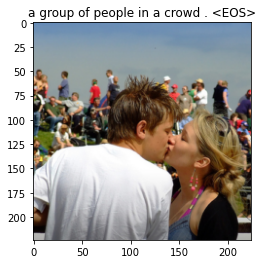

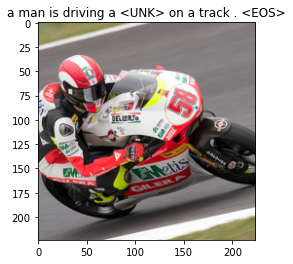

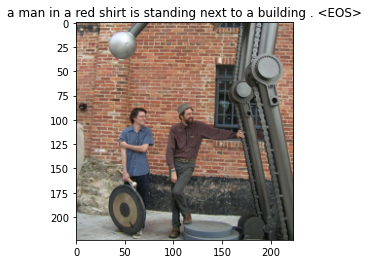

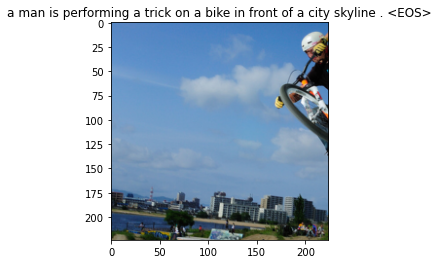

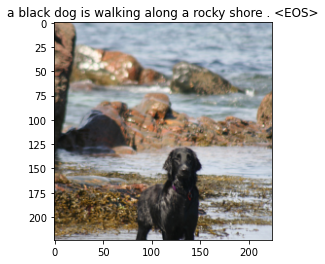

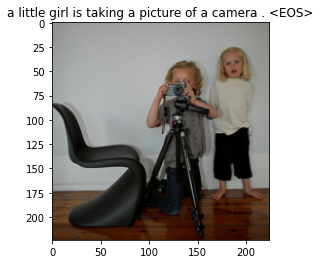

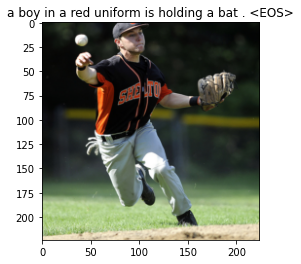

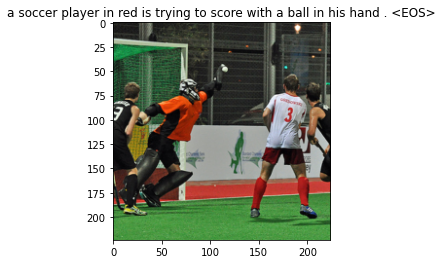

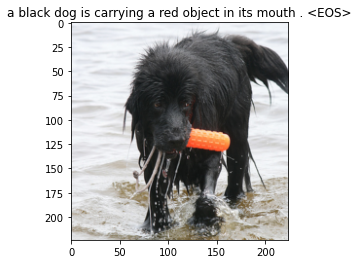

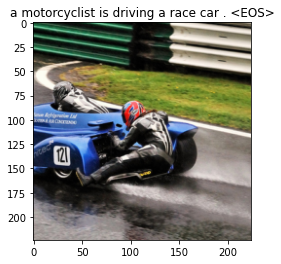

In [25]:
# Number of images that will be displayed
num_show = 10

# We make a copy so we know exactly where we are when we do 'next'
test_loader_showing = deepcopy(test_loader)

# We set the model in evaluation mode so we don't modify its weights
model.eval()
with torch.no_grad():
    # We create an iterator
    dataiter = iter(test_loader_showing)
    for i in range(num_show):
        # Get the next image
        img, _ = next(dataiter)
        # Get the features from the Encoder
        features = model.encoder(img[0:1].to(device))
        # Get the predicted caption from the Decoder
        caps, _ = model.decoder.generate_caption(features,vocab=dataset.vocab)
        # Create a readable string
        caption = ' '.join(caps)
        # Show the image
        show_image(img[0],title=caption)

We can see pretty good results.

## Feeding the model a custom image

It is also possible to feed the model a custom image. However, it is necessary to first transform the image to the correct format. That is why we need the transformations the model uses.

In [31]:
# Resized and then crops (maintains perspective)
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Directly resized (doesn't maintain perspective)
transforms_2 = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Next we can load the image and apply the necessary transformations.

In the following cell I'm assuming you have a folder named `Custom` with the custom images.

In [81]:
# Path to the custom image
img_location = DATA_LOCATION + '/Custom/woman.png' 

# Transforming the image to the correct format
img = Image.open(img_location)
img = img.convert("RGB")
img = transforms_2(img)
img = img.unsqueeze(0)

And now we can pass it to the model to get the predicted captions and show the image along the prediction as we did before.

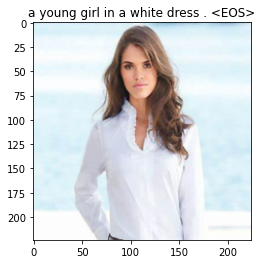

In [82]:
# Feeding the model the image
features = model.encoder(img.to(device))
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

# Showing the caption and the image
caption = ' '.join(caps)
show_image(img[0], caption)

## Converting the predicted caption to audio

If we want to convert the predicted caption to audio (for example if we want to create a system image-to-audio), we can use the function `text_to_speech()`. It is necessary to install the package `deep-phonemizer`.

For example, we can use the caption from the last image like this:

In [90]:
clean_caption = caption.rstrip(' <EOS>'); clean_caption

'a young girl in a white dress .'

In the previous cell we cleaned the caption by removing the `<EOS>` token at the end.

And now we simply have to call the function.

In [91]:
text_to_speech(clean_caption, device)

## Seeing the output of the Encoder for an image

It is interesting to see how the image is encoded by the Encoeder, this is, what are the features the CNN extracts from the image. We can visualize this with the next few cells of code.

Let's list all the images in the `Images` folder (which I assume you have), and select one of them.

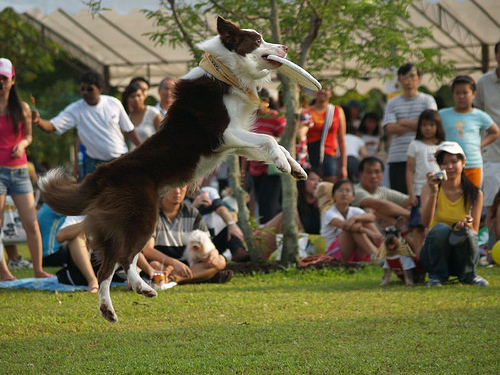

In [98]:
# Path to the folder of images
path = DATA_LOCATION + "/Images"

# Listing the images in the folder
files = [f for f in os.listdir(path) if f.endswith('.jpg')]

# Choosing an image
file = files[100]

# Opening the image
img = Image.open(os.path.join(path, file))

# Showing the image
img

Now let's transform the image as we did in previous examples.

In [99]:
# Transforming the image to the correct format
img = img.convert("RGB")
img = transforms(img)
img = img.unsqueeze(0)

And then we pass it to the Encoder to get the features.

In [101]:
# Passing the image through the encoder
features = model.encoder(img.to(device))

In [102]:
features.shape

torch.Size([1, 49, 2048])

Now we can plot this Tensor in a 2-dimensional plot with colours for the different values.

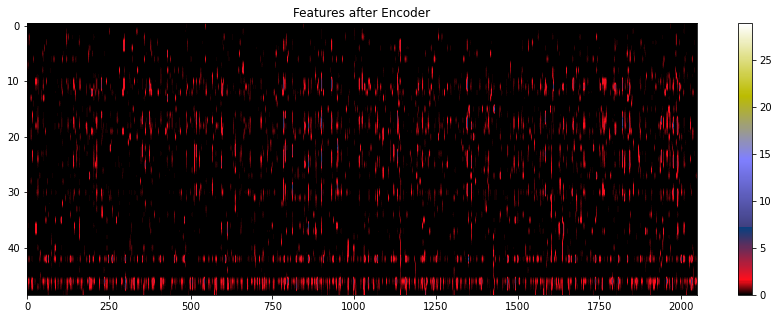

In [104]:
# Setting the size of the plot
plt.figure(figsize=(15,5))

# Creating the plot of the image
plt.imshow(features[0], cmap='gist_stern', aspect='auto')  # Display the tensor as an image

# Adding a colorbar
plt.colorbar()

# Adding a title
plt.title("Features after Encoder")

# Showing the image
plt.show()

For us humans, at a glance it is seemingly random. But for our model it is essential, as these are the encoded relevant features of the image provided.

## Visualizing the attention for a certain image

Another extremely interesting thing to visualize is the attention assigned to each part of the image. This mechanism uses the alpha scores produced in the Decoder, which map to different parts of the image and represent the "importance" of that part of the image when making the prediction of the next word.

We first load an image from the folder of `Images` as before, and apply the required transformations.

In [121]:
# Path to the folder of images
path = DATA_LOCATION + "/Images"

# Listing the images in the folder
files = [f for f in os.listdir(path) if f.endswith('.jpg')]

# Choosing an image
file = files[100]

# Opening the image
img = Image.open(os.path.join(path, file))

# Transforming the image to the correct format
img = img.convert("RGB")
img = transforms(img)
img = img.unsqueeze(0)

And then we pass the image through the model using the `get_caps_from()` function, which also returns the alpha scores. Next, we use the function `plot_attention` to map the alpha scores to the image, and make a plot for each word of the caption.

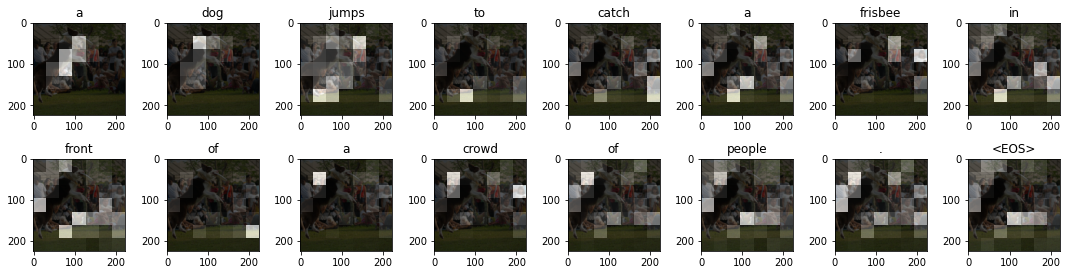

In [122]:
# Pass the image through the model
caps, alphas = get_caps_from(model, img, vocab, device)

# Plot the attention along the image (for each word in the caption)
plot_attention(img.squeeze(0), caps, alphas)

## Seeing how the embedding works inside the Decoder

In this section we will go through and visualize the embedding process inside the Decoder. The embedding maps the words of the captions to high dimensional spaces.

Let's take, for example, the captions of a certain image in the dataset. For the sake of simplicity, in the following cell I chose an image from the first batch, so the next cells don't get overcomplicated.

In [144]:
# Selecting an image from the dataset
image_num = 0

# Getting its captions (there are 5 of them in total)
captions = list(dataset.captions[(image_num)*5 : (image_num+1)*5])

# Showing the captions
captions

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

These captions are the raw captions so to speak, of the image `image_num` of the dataset.

Next, once the captions get inside the dataloader, these are processed a little bit when they get called by the `next` function. In particular, they are converted to lists of integers, one step closer to the embedding. This is why we will access the data loader in the next cells.

In [149]:
# Make a copy of the train_loader so we make sure not to modify the original
train_loader_showing = deepcopy(train_loader)

# Get the next batch of captions
_, caption = next(iter(train_loader_showing))

# Get the 5 captions corresponding to the previous image selected
captions = [caption[i] for i in range(image_num*5,(image_num+1)*5)]

# Stack the captions so they can be visualized at once
captions = torch.stack(captions); captions

tensor([[   1,    4,   28,    8,    4,  195,  151,   17,   32,   67,    4,  353,
           11,  711,    8,   24,    3,  496,    5,    2,    0,    0,    0],
        [   1,    4,    7,  316,   76,    4,  157,   74,    5,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,    9,    7,   32,   76,    4,  157, 2409,    5,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,    9,    7,   32,   10,  711,   27,  104, 2409,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,    9,    7,    8,    4,  195,  151,  316,   76,    4,  157,
            3,    5,    2,    0,    0,    0,    0,    0,    0,    0,    0]])

These are the 5 captions shown above but converted to lists of integers. The conversion is done using the `stoi` dictionary of the vocabulary of the dataset (which is an instance of the Vocabulary class). We can be sure these correspond to the captions shown above because the train test split is ordered (meaning that it takes the dataset and the first X% corresponds to the train set), and also because we are just calling `next` once, which corresponds to the first batch. If we where to set `image_num` to a higher number than the `batch_size`, we would have to call `next` again (to access the next batch of data).

In [125]:
# Generating an intance of the embedding class from torch
vocab_size = len(dataset.vocab)
embed_size = 300
embdedding = nn.Embedding(vocab_size, embed_size)

In [126]:
# Embedding the 5 captions
embedded = embdedding(captions)

In [127]:
# First caption embedded
embedded[0]

tensor([[ 0.2031, -2.8218, -0.7436,  ..., -0.7117,  1.5870,  1.5657],
        [-0.3664,  1.0827,  0.7070,  ..., -1.2596,  0.6014,  0.4932],
        [-1.2455,  1.0259, -1.9643,  ...,  0.5534,  0.0737, -0.9579],
        ...,
        [ 1.1295,  0.3511,  0.0182,  ...,  0.6757, -0.2192, -0.8884],
        [ 2.9461, -1.4919,  0.0531,  ...,  1.1141, -0.0781,  1.3611],
        [-0.0475,  0.9723,  0.6307,  ..., -1.0740, -0.0290, -0.1695]],
       grad_fn=<SelectBackward0>)

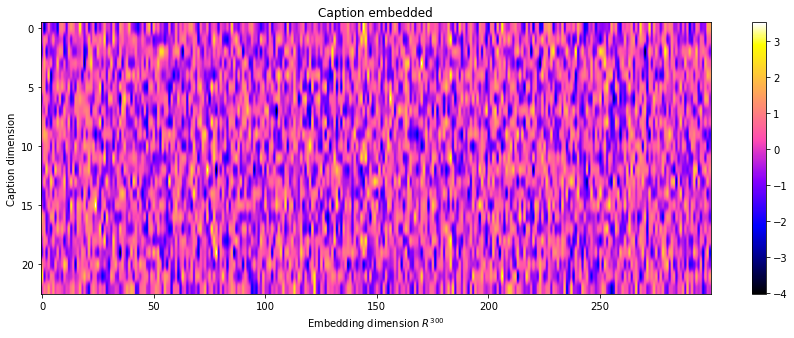

Caption embedded: tensor([   1,    4,    9,    7,  114,    8, 1447,   77,    8,   23,   11,    4,
         325,  643,   12,  104,  229,    8,    4, 1301,    5,    2,    0])


In [128]:
plt.figure(figsize=(15,5))
plt.imshow(embedded[0].detach().numpy(), cmap='gnuplot2', aspect='auto')  # Display the tensor as an image
plt.colorbar()
plt.title("Caption embedded")
plt.ylabel("Caption dimension")
plt.xlabel("Embedding dimension $R^{300}$")
plt.show()
print("Caption embedded:", captions[0])

## Visualizing the attention weights for a certain caption

In [ ]:
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

In [ ]:
alpha = torch.tensor(alphas[0])

In [ ]:
alpha.shape # the first dimension is the number of words of the caption

In [ ]:
alpha_values = np.array(alpha[0].tolist())
matrix = alpha_values.reshape((7, 7))
plt.imshow(matrix, cmap='viridis')  # You can choose a different colormap if desired
plt.colorbar()
plt.title('Alpha scores (attention)')
plt.show()

In [ ]:
features.shape

In [ ]:
attention_weights = features * alpha.unsqueeze(2)
attention_weights = attention_weights.sum(dim=1)

In [ ]:
len(attention_weights[0])

In [ ]:
attention_weights

In [ ]:
plt.figure(figsize=(15,4))
plt.bar(range(len(features.sum(dim=1)[0])), features.sum(dim=1)[0], color='green')
plt.title('Features vector (before being weighted by alpha scores)') # Dictates where to focus the attention
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
plt.bar(range(len(attention_weights[0])), attention_weights[0], color='red')
plt.title('Context vector (weighted features)') # Dictates where to focus the attention
plt.show()